In [1]:
#Importing necessery libraries and Functions from other files
import numpy as np   #primarly for arrays and computations
import astropy.units as u   #standard library for astronomy units
import astropy.constants as const   #library for astronomy constants
import matplotlib.pyplot as plt   #library to plot on python
from matplotlib.animation import FuncAnimation #to make an animation for the graph
import imageio #to make gif for graph

In [2]:
#function: To get a file and extract the information frmo the first line, second line
#          and the rest of the data starting from line 4 into a sepcial numpy array
#Argument: location of file on your computer, including its name, assumed to be string
#Return: time is the total time of the system, total is the total number of particles
#        and data is a special numpy array.
def Read(file_location):
    file = open(file_location, 'r')
    #takes the first line (assumed to be label,value format) and records only 
    #the value, convert to float and attach units of Myr
    time = float(file.readline().split()[1])*u.Myr 
    #takes second line, that has same formatting, however total has to be
    #integer since particles are whole numbers
    total = int(file.readline().split()[1]) 
    file.close()  
    #gets the rest of the data starting from line 4 until the end of the file
    #and stores it in a special list with format 
    #[column_type i.e(#type,m,x,y,z,vx,vy,vz)][row_#]
    #type# meaning --> 1=DarkMatter, 2=DiskStars 3=BulgeStars
    data = np.genfromtxt(file_location,dtype=None,names=True,skip_header=3)
    return time, total, data

In [3]:
#The following files are credited towards Professor Gurtina
#Taken right from HW solutions
def COMdefine(a,b,c,m):
    ''' Method to compute the COM of a generic vector quantity by direct weighted averaging.

    PARAMETERS
    ----------
    a : `float or np.ndarray of floats`
        first vector component
    b : `float or np.ndarray of floats`
        second vector component
    c : `float or np.ndarray of floats`
        third vector component
    m : `float or np.ndarray of floats`
        particle masses

    RETURNS
    -------
    a_com : `float`
        first component on the COM vector
    b_com : `float`
        second component on the COM vector
    c_com : `float`
        third component on the COM vector
    '''
    # write your own code to compute the generic COM 
    #using Eq. 1 in the homework instructions
    # xcomponent Center of mass
    a_com = np.sum(a*m)/np.sum(m)
    # ycomponent Center of mass
    b_com = np.sum(b*m)/np.sum(m)
    # zcomponent Center of mass
    c_com = np.sum(c*m)/np.sum(m)

    # return the 3 components separately
    return a_com, b_com, c_com
def COM_P(ptype, data,delta, volDec = 1):
    '''Method to compute the position of the center of mass of the galaxy 
    using the shrinking-sphere method.

    PARAMETERS
    ----------
    delta : `float`
        error tolerance in kpc. 
    volDEC:  'float'
        factor by which the radius of the sphere is decreased during 
        each iteration
    RETURNS
    ----------
    p_COM : `np.ndarray of astropy.Quantity'
        3-D position of the center of mass in kpc
    '''                                                                     
    index = np.where(data['type'] == ptype)
    # Center of Mass Position                                                                                      
    ###########################    
    x = data['x'][index]
    y = data['y'][index]
    z = data['z'][index]
    m = data['m'][index]
    # Try a first guess at the COM position by calling COMdefine                                                   
    x_COM, y_COM, z_COM = COMdefine(x, y, z, m)
    # compute the magnitude of the COM position vector.
    # write your own code below
    r_COM = np.sqrt(x_COM**2 + y_COM**2 + z_COM**2)


    # iterative process to determine the center of mass                                                            

    # change reference frame to COM frame                                                                          
    # compute the difference between particle coordinates                                                          
    # and the first guess at COM position
    # write your own code below
    x_new = x - x_COM
    y_new = y - y_COM
    z_new = z - z_COM
    r_new = np.sqrt(x_new**2.0 + y_new**2.0 +z_new**2.0)

    # find the max 3D distance of all particles from the guessed COM                                               
    # HOWEWORK 6: will re-start at a reduced radius specified by input volDec
    r_max = max(r_new)/volDec

    # pick an initial value for the change in COM position                                                      
    # between the first guess above and the new one computed from half that volume
    # it should be larger than the input tolerance (delta) initially
    change = 1000.0

    # start iterative process to determine center of mass position                                                 
    # delta is the tolerance for the difference in the old COM and the new one.    

    while (change > delta):
        # select all particles within the reduced radius (starting from original x,y,z, m)
        # write your own code below (hints, use np.where)
        index2 = np.where(r_new < r_max)
        x2 = x[index2]
        y2 = y[index2]
        z2 = z[index2]
        m2 = m[index2]


        # Refined COM position:                                                                                    
        # compute the center of mass position using                                                                
        # the particles in the reduced radius
        # write your own code below
        x_COM2, y_COM2, z_COM2 = COMdefine(x2,y2,z2,m2)

        # compute the new 3D COM position
        # write your own code below
        r_COM2 = np.sqrt(x_COM2**2 + y_COM2**2 + z_COM2**2) 

        # determine the difference between the previous center of mass position                                    
        # and the new one.                                                                                         
        change = np.abs(r_COM - r_COM2)
        # uncomment the following line if you want to check this                                                                                               
        # print ("CHANGE = ", CHANGE)                                                                                     

        # Before loop continues, reset : r_max, particle separations and COM                                        

        # reduce the volume by a factor of 2 again                                                                 
        r_max /= 2.0
        # check this.                                                                                              
        #print ("maxR", r_max)                                                                                      

        # Change the frame of reference to the newly computed COM.                                                 
        # subtract the new COM
        # write your own code below
        x_new = x - x_COM2
        y_new = y - y_COM2
        z_new = z - z_COM2
        r_new = np.sqrt(x_new**2 + y_new**2 + z_new**2)


        # set the center of mass positions to the refined values                                                   
        x_COM = x_COM2
        y_COM = y_COM2
        z_COM = z_COM2
        r_COM = r_COM2

        # create an array  to store the COM position                                                                                                                                                       
        p_COM = np.array([x_COM, y_COM, z_COM])

    # set the correct units using astropy and round all values
    # and then return the COM positon vector
    # write your own code below
    return np.around(p_COM, 2)*u.kpc


def massEnclosed(data, ptype, radii):
    '''This method computes and returns the mass profile of the galaxy
    based on the specified particle type.

    PARAMETERS
    ----------
    ptype : `int; 1, 2, or 3`
        particle type
    radii : `np.ndarray`
        array of radius bin edges, in kpc

    RETURNS
    -------
    m_enc : `np.ndarray`
        array containing the mass within the radii specified 
        by r, in Msun
    '''


    com_pos = COM_P(ptype, data, 0.1)

    # create an array to store indexes of particles of desired Ptype                                                
    index = np.where(data['type'] == ptype)
    x = data['x']*u.kpc
    y= data['y']*u.kpc
    z = data['z']*u.kpc
    m = data['m']
    # Store positions of particles of given ptype from the COMP. 
    xG = x[index] - com_pos[0]
    yG = y[index] - com_pos[1]
    zG = z[index] - com_pos[2]

    # Compute the mag. of the 3D radius
    rG = np.sqrt(xG**2 + yG**2 + zG**2)

    # store mass of particles of a given ptype
    mG = m[index]

    # Array to store enclosed mass as a function of the 
    #input radius array
    m_enc = np.zeros(np.size(radii))
    # equivalently: 
    # m_enc = np.zeros_like(radii)

    # loop through the radii array
    for i in range(np.size(radii)):
        # Only want particles within the given radius
        indexR = np.where(rG <  radii[i]*u.kpc)
        m_enc[i] = np.sum(mG[indexR])         

    # return the array of enclosed mass with appropriate units
    return m_enc*u.Msun*1e10
def circularVelocity(data, ptype, radii):
    '''This method computes and returns the rotation curve of the galaxy
    based on the specified particle type.

    PARAMETERS
    ----------
    ptype : `int; 1, 2, or 3`
        particle type
    radii : `np.ndarray`
        array of radius bin edges, in kpc

    RETURNS
    -------
    v_circ : `np.ndarray`
        array containing the circular orbital velocity at
        the radii specified by r, in km/s
    '''

    # compute the mass enclosed for the given ptype
    m_enc = massEnclosed(data, ptype,radii)

    # Determine the circular speed as a function of 
    # input radius assuming spherical symmetry 
    # note that radius needs units 
    # This will return units of kpc/Gyr
    G = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun)
    v_circ = np.sqrt(G*m_enc/(radii*u.kpc))

    # round and return the array in km/s
    return np.around(v_circ.to(u.km/u.s), 2)

In [4]:
def filename(gal, numb):
    '''This function creates the file name needed to acsses the data and files and converts values less 
    than 100 into 3 digit numbers that have a leading 0
    
    Arguments
    ----------
    gal = str
        a string that describes the name of the galaxy, can either be MW, M33, M31
    numb = int
        an integer that coresponds to the snapshot number, ranges between 0 and 801
    Returns
    -------
    returns the whole string name of where the file of the galaxy name and assosciated snapshot number is 
    '''
    #start locates the file folder holding all the data
    start = '''C:\\Users\mcorb\OneDrive\Desktop\School Work\School Year\Spring 2023\ASTR400B\\400B_2023_Corbeanu\Research Assignment\Final Project\Data\\'''
    #converts number into a 3 length number, if sub 100 adds leading 0s
    numb = f'{numb:03d}'
    #return the a whole string combining start and numb as well as galaxy name
    return start + f'{gal}_{numb}.txt'  
#test to see if string works and prints correctly
print(filename('M33', 0))

C:\Users\mcorb\OneDrive\Desktop\School Work\School Year\Spring 2023\ASTR400B\400B_2023_Corbeanu\Research Assignment\Final Project\Data\M33_000.txt


started!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
2

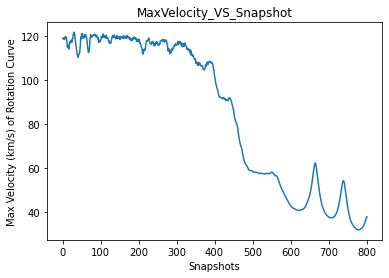

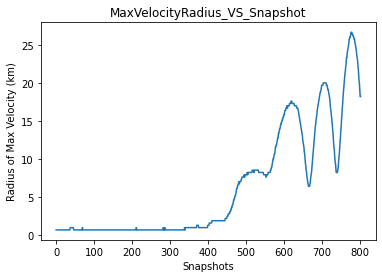

In [17]:
print('started!')  #to test and make sure file is running
radii = np.linspace(0.1, 30, 100)  #creates radii values
max_vel = []  #initialize lst of values to append later on
max_vel_R = []
time = []
for val in range(0,802,1):
    name = filename('M33', val)  #get the name of needed file
    t, total, data = Read(name)  #get the data for the needed file
    profile = circularVelocity(data, 2,radii).value  #get the circular velocity information
    max_value = max(profile)  #find the max circular velocity
    max_location = np.where(profile == max_value)  #gets index of where max_value is and pinpoints respective radius
    print(val)  #to keep count of where we are in the code
    max_vel_R.append(radii[max_location][0])  #append to lst
    time.append(val)  #append to lst
    max_vel.append(max_value)  #append to lst
plt.plot(time, max_vel)  #plots time versus max velocity
plt.title('MaxVelocity_VS_Snapshot')
plt.xlabel('Snapshots')
plt.ylabel('Max Velocity (km/s) of Rotation Curve')
plt.savefig('MaxVelocity_VS_Snapshot.png')
plt.show()
plt.plot(time, max_vel_R)  #plots time versus max velocity radius location
plt.title('MaxVelocityRadius_VS_Snapshot')
plt.xlabel('Snapshots')
plt.ylabel('Radius of Max Velocity (km)')
plt.savefig('MaxVelocityRadius_VS_Snapshot.png')
plt.show()

In [20]:
#Showing how the radial velocity curve's shape changes at different snapshots
#utalizes the same code as above, just running for a different test
radii = np.linspace(0.1, 30, 100)
def create_frame(snapshot):
    '''
    creates an singular circular velocity graph for a single instance of snapshot
    
    Arguments
    ---------
    snapshot = int
        a value that indicates what snapshot file we are trying to extract information from
    returns
    -------
    none
        there is no return on this function, instead we are just saving a bunch of pictures as png's
    '''
    name = filename('M33', snapshot)
    t, total, data = Read(name)
    profile = circularVelocity(data, 2,radii).value
    plt.plot(radii,profile)
    plt.title(f'Radial Velocity Shape at Snapshot {snapshot}')
    plt.ylabel('velocity in km/s')
    plt.xlabel('Radius in km')
    plt.savefig(f'Frame{snapshot} of M33 animation.png', transparent = False, facecolor = 'white')
    plt.plot(radii,profile)
    plt.title(f'Radial Velocity at Snapshot {snapshot}')
    plt.ylim([0,125])
    plt.ylabel('velocity in km/s')
    plt.xlabel('Radius in km')
    plt.savefig(f'Frame{snapshot} of M33 animation.png', transparent = False, facecolor = 'white')
    plt.close()
    plt.close()
time = np.arange(0,802,1)  #set up the time insatances 
frames = []  #an array set up to hold images for when using them in a gif
for t in time:
    print(t)   #keep count of what time we are while code is running
    create_frame(t)  #Runs the code respective to value t
for t in time:
    print(t)  #keep count
    image = imageio.v2.imread(f'./Frame{t} of M33 animation.png')  #locates the image needed and pulls up the location details
    frames.append(image)  #appends the image to the array frames
imageio.mimsave('./RircularVelocity Shape Change Through Time GIF.gif', frames , duration = 30)  #saves array into a gif and runs it at 1 frame every 30ms

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27